# Grounding ChatGPT in the world with Wolfram Alpha

In this Jupyter notebook, we will explore the potential of integrating ChatGPT with Wolfram|Alpha as mentioned in Stephen Wolfram's recent blog post, 
<a href="https://writings.stephenwolfram.com/2023/01/wolframalpha-as-the-way-to-bring-computational-knowledge-superpowers-to-chatgpt/">Wolfram Alpha as the Way to Bring Computational Knowledge Superpowers to ChatGPT</a>. 
As Stephen states in the post, ChatGPT excels in the "human-like parts" of language processing but may struggle with precise answers. 
By connecting ChatGPT with Wolfram|Alpha and its vast computational knowledge, we aim to bridge this gap and provide ChatGPT with the "grounding" 
into the real world that large language models like GPT are missing. We will create reports with real data and visuals to showcase the potential of this integration. Let's get started!

Before we start, you will need to get an API key from Wolfram|Alpha and OpenAI.
Go to [Wolfram|Alpha]("https://developer.wolframalpha.com/portal/myapps/") and [OpenAI]("https://beta.openai.com/") to get your API keys.
Add your keys to your environment variables as `OPENAI_API_KEY` and `WOLFRAM_API_KEY`.
```bash
export OPENAI_API_KEY=""
export WOLFRAM_APPID=""
```

After that, you can run the following cell to import the necessary libraries.

In [56]:
# !pip3 install wolframalpha
# !pip3 install openai

Import packages :

In [47]:
from pprint import pprint # pretty print
import requests # for making HTTP requests
import os # for getting environment variables
import urllib.parse # for encoding the query
import openai # openai API
import wolframalpha # wolframalpha API
import matplotlib.pyplot as plt # for plotting
from PIL import Image # for image manipulation
import textwrap # for wrapping text

In [57]:
%run utils.py

Get the API keys from your environment variables and set them to variables :

In [49]:
# Read the API key from the environment variable
openai_app_id = os.environ['OPENAI_API_KEY']
wolframalpha_app_id = os.environ['WOLFRAMALPHA_API_KEY']

Make the WolframAlpha client. This will be used to query Wolfram|Alpha for data and visuals.

In [50]:
def wolframAlpha_client(query: str, includeplot : bool = False) -> str:
    """ Get the answer from WolframAlpha 
    Args:
        query (str): The query to ask WolframAlpha
    Returns:
        str: The answer from WolframAlpha
    """
    # Encode the query
    query = urllib.parse.quote_plus(query)
    # Make the request
    query_url = f"http://api.wolframalpha.com/v2/query?" \
                f"appid={wolframalpha_app_id}" \
                f"&input={query}" \
                f"&output=json"
    if includeplot :
        query_url += f"&includepodid=Plot"           
    # Get the response
    report_json = requests.get(query_url).json()
    # Return the answer
    return report_json

Make the OpenAI client. This will be used to query OpenAI for the GPT-3 completion.

In [51]:
def gpt_client(prompt: str) -> str:
    """  Get the answer from GPT-3
    Args:
        query (str): The query to ask GPT-3
    Returns:
        str: The answer from GPT-3
    """
    ## Call the API key under your account (in a secure way)
    openai.api_key = openai_app_id
    response = openai.Completion.create(
        engine="text-davinci-003", # the model
        prompt =  prompt, # the prompt
        temperature = 0.0, # temperature : the higher the temperature, the more random the output
        top_p = 1, # the top_p, 1 means no sampling
        max_tokens = 1264, # the max number of tokens to generate
        frequency_penalty = 0, # the frequency penalty
        presence_penalty = 0 # the presence penalty
    )
    # Return the answer
    return response.choices[0].text

Now we can start the fun part! We will start by defining a function that will take in a prompt and return a response from the wolframAlpha client.
After, some post-processing (see the function wolframAlpha_report below), we will be able to get a report with data and visuals from Wolfram|Alpha.
We can use that information to create a prompt for GPT-3 to use to generate a response.
Finally, we will merge the response from Wolfram|Alpha and GPT-3 to create a report with data and visuals.

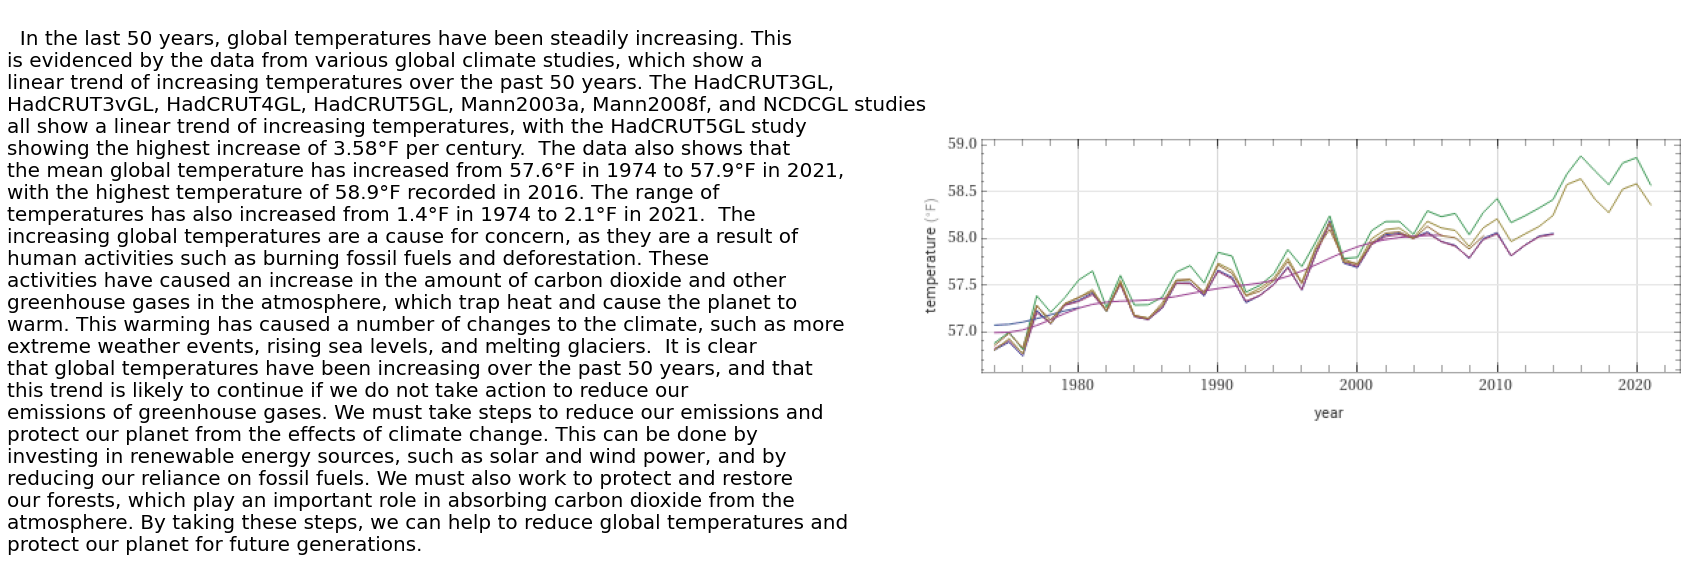

<Figure size 432x288 with 0 Axes>

In [59]:

query = 'analyze global temperature in the last 50 years'
report_json = wolframAlpha_client(query)
report_prompt = wolframAlpha_report(report_json)
prompt = query.capitalize() + ".\n" + "Write an essay.\n" + "Use this data:\n" + report_prompt["report"] +"\nDo not show tables."
gpt_output = gpt_client(prompt)
show_text_and_image(gpt_output, report_prompt["imgs_files"][0])
